# Red Neuronal en Python (mejorada)

Crearemos una red neuronal simple, con 3 capas, neuronas con valores de entrada -1 a 1 y de salida 0 a 1 indicando encender o no los motores de un coche Arduino.

In [1]:
import numpy as np

# Creamos la clase 
class NeuralNetwork:

    def __init__(self, layers, activation='tanh'):
        if activation == 'sigmoid':
            self.activation = sigmoid
            self.activation_prime = sigmoid_derivada
        elif activation == 'tanh':
            self.activation = tanh
            self.activation_prime = tanh_derivada

        # inicializo los pesos
        self.weights = []
        self.deltas = []
        # capas = [2,3,4]
        # rando de pesos varia entre (-1,1)
        # asigno valores aleatorios a capa de entrada y capa oculta
        for i in range(1, len(layers) - 1):
            r = 2*np.random.random((layers[i-1] + 1, layers[i] + 1)) -1
            self.weights.append(r)
        # asigno aleatorios a capa de salida
        r = 2*np.random.random( (layers[i] + 1, layers[i+1])) - 1
        self.weights.append(r)

    def fit(self, X, y, learning_rate=0.2, epochs=100000):
        # Agrego columna de unos a las entradas X
        # Con esto agregamos la unidad de Bias a la capa de entrada
        ones = np.atleast_2d(np.ones(X.shape[0]))
        X = np.concatenate((ones.T, X), axis=1)
        
        for k in range(epochs):
            i = np.random.randint(X.shape[0])
            a = [X[i]]

            for l in range(len(self.weights)):
                    dot_value = np.dot(a[l], self.weights[l])
                    activation = self.activation(dot_value)
                    a.append(activation)
            # Calculo la diferencia en la capa de salida y el valor obtenido
            error = y[i] - a[-1]
            deltas = [error * self.activation_prime(a[-1])]
            
            # Empezamos en el segundo layer hasta el ultimo
            # (Una capa anterior a la de salida)
            for l in range(len(a) - 2, 0, -1): 
                deltas.append(deltas[-1].dot(self.weights[l].T)*self.activation_prime(a[l]))
            self.deltas.append(deltas)

            # invertir
            # [level3(output)->level2(hidden)]  => [level2(hidden)->level3(output)]
            deltas.reverse()

            # backpropagation
            # 1. Multiplcar los delta de salida con las activaciones de entrada 
            #    para obtener el gradiente del peso.
            # 2. actualizo el peso restandole un porcentaje del gradiente
            for i in range(len(self.weights)):
                layer = np.atleast_2d(a[i])
                delta = np.atleast_2d(deltas[i])
                self.weights[i] += learning_rate * layer.T.dot(delta)

            if k % 10000 == 0: print('epochs:', k)

    def predict(self, x): 
        ones = np.atleast_2d(np.ones(x.shape[0]))
        a = np.concatenate((np.ones(1).T, np.array(x)), axis=0)
        for l in range(0, len(self.weights)):
            a = self.activation(np.dot(a, self.weights[l]))
        return a

    def print_weights(self):
        print("LISTADO PESOS DE CONEXIONES")
        for i in range(len(self.weights)):
            print(self.weights[i])

    def get_weights(self):
        return self.weights
    
    def get_deltas(self):
        return self.deltas

# Al crear la red, podremos elegir entre usar la funcion sigmoid o tanh
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

def sigmoid_derivada(x):
    return sigmoid(x)*(1.0-sigmoid(x))

def tanh(x):
    return np.tanh(x)

def tanh_derivada(x):
    return 1.0 - x**2

## Comportamiento del Coche Robot

Crearemos una red neuronal que nos dará los pesos para las conexiones que utilizaremos en un coche robot Arduino

In [25]:
# Red Coche para Evitar obstáculos
nn = NeuralNetwork([2,3,4],activation ='tanh')
X = np.array([[-1, 0],   # sin obstaculos
              [-1, 1],   # sin obstaculos
              [-1, -1],  # sin obstaculos
              [0, -1],   # obstaculo detectado a derecha
              [0,1],     # obstaculo a izq
              [0,0],     # obstaculo centro
              [1,1],     # demasiado cerca a derecha
              [1,-1],    # demasiado cerca a izq
              [1,0]      # demasiado cerca centro
             ])
# las salidas 'y' se corresponden con encender (o no) los motores
y = np.array([[1,0,0,1], # avanzar
              [1,0,0,1], # avanzar
              [1,0,0,1], # avanzar
              [0,1,0,1], # giro derecha
              [1,0,1,0], # giro izquierda (cambie izq y derecha)
              [1,0,0,1], # avanzar
              [0,1,1,0], # retroceder
              [0,1,1,0], # retroceder
              [0,1,1,0]  # retroceder
             ])
nn.fit(X, y, learning_rate=0.03,epochs=40001)

def valNN(x):
    return (int)(abs(round(x)))

index=0
for e in X:
    prediccion = nn.predict(e)
    print("X:",e,"esperado:",y[index],"obtenido:", valNN(prediccion[0]),valNN(prediccion[1]),valNN(prediccion[2]),valNN(prediccion[3]))
    #print("X:",e,"y:",y[index],"Network:",prediccion)
    index=index+1

epochs: 0
epochs: 10000
epochs: 20000
epochs: 30000
epochs: 40000
X: [-1  0] esperado: [1 0 0 1] obtenido: 1 0 0 1
X: [-1  1] esperado: [1 0 0 1] obtenido: 1 0 0 1
X: [-1 -1] esperado: [1 0 0 1] obtenido: 1 0 0 1
X: [ 0 -1] esperado: [0 1 0 1] obtenido: 0 1 0 1
X: [0 1] esperado: [1 0 1 0] obtenido: 1 0 1 0
X: [0 0] esperado: [1 0 0 1] obtenido: 1 0 0 1
X: [1 1] esperado: [0 1 1 0] obtenido: 0 1 1 0
X: [ 1 -1] esperado: [0 1 1 0] obtenido: 0 1 1 0
X: [1 0] esperado: [0 1 1 0] obtenido: 0 1 1 0


# Graficamos la función coste 

Vemos como el gradiente desciende y disminuye el error a medida que pasan las iteraciones de aprendizaje

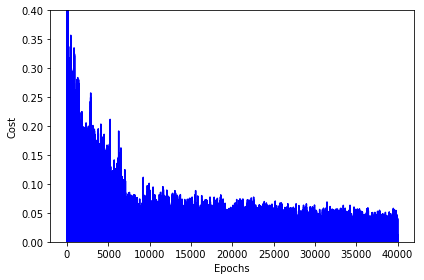

In [26]:
import matplotlib.pyplot as plt

deltas = nn.get_deltas()
valores=[]
index=0
for arreglo in deltas:
    valores.append(arreglo[1][0] + arreglo[1][1])
    index=index+1

plt.plot(range(len(valores)), valores, color='b')
plt.ylim([0, 0.4])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

# Generamos el código para Arduino

In [27]:
def to_str(name, W):
    s = str(W.tolist()).replace('[', '{').replace(']', '}')
    return 'float '+name+'['+str(W.shape[0])+']['+str(W.shape[1])+'] = ' + s + ';'

In [28]:
# Obtenermos los pesos entrenados para poder usarlos en el codigo de arduino
pesos = nn.get_weights();

print('// Reemplazar estas lineas en tu codigo arduino:')
print('// float HiddenWeights ...')
print('// float OutputWeights ...')
print('// Con lo pesos entrenados.')
print('\n')
print(to_str('HiddenWeights', pesos[0]))
print(to_str('OutputWeights', pesos[1]))

// Reemplazar estas lineas en tu codigo arduino:
// float HiddenWeights ...
// float OutputWeights ...
// Con lo pesos entrenados.


float HiddenWeights[3][4] = {{-0.7960407385601368, 0.33445223923885203, 1.960425026701174, -0.2188265940282402}, {3.2656011309214015, -3.6013913588454005, -0.29096408903685744, -2.9388553664766386}, {1.446933199813894, 1.1486435763683631, 0.3135522324567505, -0.9821514189870271}};
float OutputWeights[4][4] = {{-0.5877653512662401, 1.2155643742120474, 2.031535401995985, -0.600509803082288}, {1.5646656113326125, -1.4443245182339164, -0.14615109999534517, -0.30734376440418343}, {1.200279804931951, 1.5841869308538188, 1.5974846833590683, 2.053825687728427}, {-0.9889240481130815, 1.1326242970187457, 0.6332460304988264, 1.6646621069357435}};


Lee el artículo completo en www.aprendemachinelearning.com

Sigeme en Twitter @jbagnato